In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, ScalarFormatter, PercentFormatter

In [1]:
df = pd.read_parquet("musc/data/data.parquet")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3830 entries, 0 to 3829
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             3830 non-null   object 
 1   image            3830 non-null   object 
 2   college          3830 non-null   object 
 3   department       3784 non-null   object 
 4   rank             3830 non-null   object 
 5   phone            1900 non-null   object 
 6   email            3810 non-null   object 
 7   directory_page   3830 non-null   object 
 8   image_path       3830 non-null   object 
 9   name_gender      3830 non-null   object 
 10  name_ethnicity   3830 non-null   object 
 11  image_age        2049 non-null   float64
 12  image_gender     2049 non-null   object 
 13  image_ethnicity  2049 non-null   object 
dtypes: float64(1), object(13)
memory usage: 419.0+ KB


,name,image,college,department,rank,phone,email,directory_page,image_path,name_gender,name_ethnicity,image_age,image_gender,image_ethnicity
0,"Aaronson, Ian A MD",https://muschealth.org/MUSCApps/HealthAssets/P...,College of Medicine,Urology,Professor,(843) 792-5347,aaronson@musc.edu,A,/Users/eczech/data/musc_directory/images/aaron...,male,nh_white,43.0,Man,white
1,"Abajue, Uzoamaka",https://muschealth.org/MUSCApps/HealthAssets/P...,College of Pharmacy,COP Clinical Pharmacy and Outcome Sciences,Instructor,None,abajue@musc.edu,A,/Users/eczech/data/musc_directory/images/NoIma...,unknown,nh_black,NaN,None,None
2,"Abbott, Andrea M. MD, MSCR",https://muschealth.org/MUSCApps/HealthAssets/P...,College of Medicine,Surgery,Associate Professor,(843) 876-0179,abbottan@musc.edu,A,/Users/eczech/data/musc_directory/images/Abbot...,female,nh_white,34.0,Woman,white
3,"Abboy, Chandar MD",https://muschealth.org/MUSCApps/HealthAssets/P...,College of Medicine,Medicine,Instructor,None,abboy@musc.edu,A,/Users/eczech/data/musc_directory/images/NoIma...,male,nh_white,NaN,None,None
4,"Abdallah, Hatem MD",https://muschealth.org/MUSCApps/HealthAssets/P...,College of Medicine,Surgery,Instructor,None,abdallah@musc.edu,A,/Users/eczech/data/musc_directory/images/Abdal...,male,nh_white,23.0,Man,latino hispanic


In [2]:
df['department'].value_counts()

Medicine                                                             528
Pediatrics                                                           354
Psychiatry and Behavioral Sciences                                   289
Family Medicine                                                      169
Oral Rehabilitation                                                  162
Surgery                                                              155
AHEC                                                                 153
Anesthesia and Perioperative Medicine                                142
Clinical Sciences                                                    135
Emergency Medicine                                                   123
Rehabilitation Sciences                                              122
COP Clinical Pharmacy and Outcome Sciences                           113
Department of Nursing                                                101
Radiology and Radiological Science                 

In [3]:
df['image_ethnicity'].value_counts()

white              1433
latino hispanic     203
asian               158
middle eastern      123
black                87
indian               45
Name: image_ethnicity, dtype: int64

In [4]:
df['name_ethnicity'].value_counts()

nh_white    3286
asian        238
hispanic     163
nh_black     143
Name: name_ethnicity, dtype: int64

In [5]:
def get_clean_data():
    return (
        pd.read_parquet("/Users/eczech/data/musc_directory/data.parquet")
        .assign(gender=lambda df: df['image_gender'].combine_first(df['name_gender']).str.lower().str.title())
        .assign(gender=lambda df: df['gender'].map({'Man': 'Male', 'Woman': 'Female', 'Mostly_Female': 'Female', 'Mostly_Male': 'Male', 'Andy': 'Unknown'}).fillna(df['gender']))
        .assign(ethnicity=lambda df: df['image_ethnicity'].combine_first(df['name_ethnicity']).str.lower().str.title())
        .assign(ethnicity=lambda df: df['ethnicity'].map({'Nh_White': 'White', 'Latino Hispanic': 'Hispanic', 'Nh_Black': 'Black'}).fillna(df['ethnicity']))
    )

display(
    get_clean_data()
    ['gender'].fillna('na').value_counts()
)

display(
    get_clean_data()
    ['ethnicity'].fillna('na').value_counts()
)


Male       2227
Female     1434
Unknown     169
Name: gender, dtype: int64

White             2983
Hispanic           267
Asian              263
Black              149
Middle Eastern     123
Indian              45
Name: ethnicity, dtype: int64

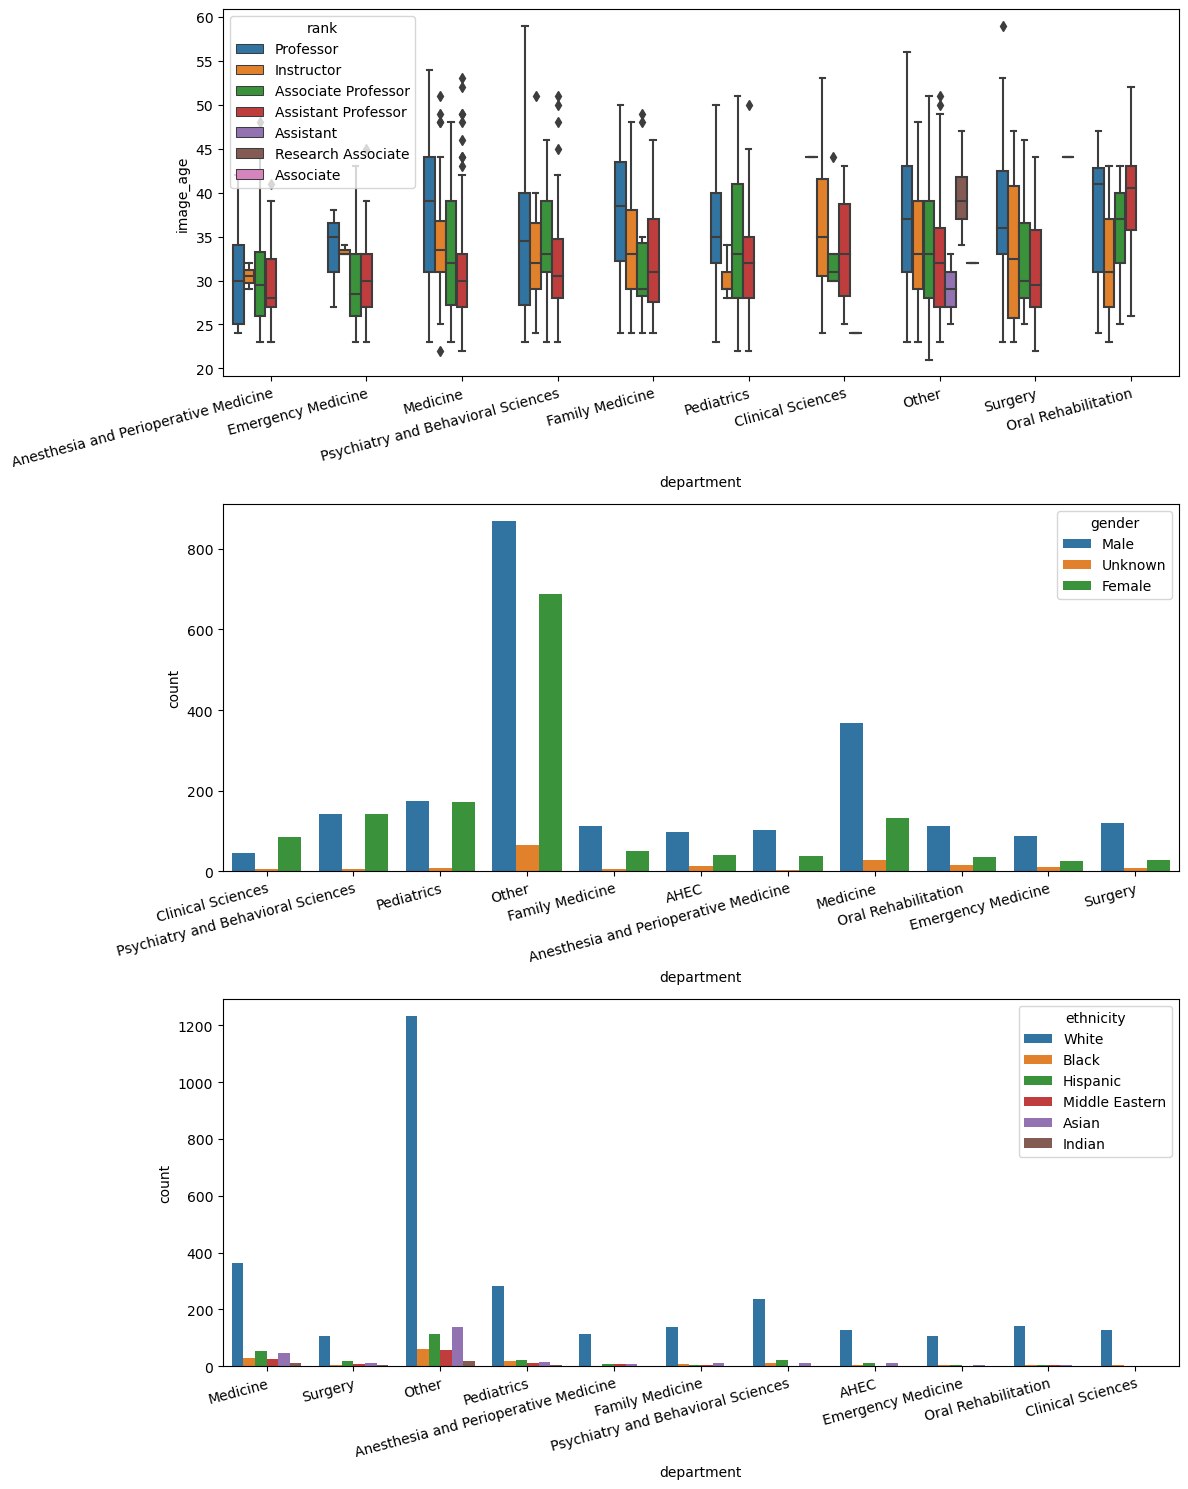

In [7]:

def visualize():
    df = get_clean_data()

    top_departments = df['department'].value_counts().head(10).index
    df['department'] = df['department'].apply(lambda x: x if x in top_departments else 'Other')
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    median_age_by_department = df.groupby('department')['image_age'].median().dropna().sort_values()
    gender_count_by_department = df.groupby(['department', 'gender']).size().unstack().fillna(0)
    gender_count_by_department['gender_ratio'] = gender_count_by_department['Male'] / (gender_count_by_department['Male'] + gender_count_by_department['Female'])
    sorted_gender_departments = gender_count_by_department['gender_ratio'].sort_values().index
    ethnicity_count_by_department = df.groupby(['department', 'ethnicity']).size().unstack().fillna(0)
    ethnicity_count_by_department['ethnicity_ratio'] = ethnicity_count_by_department['White'] / ethnicity_count_by_department.sum(axis=1)
    sorted_ethnicity_departments = ethnicity_count_by_department['ethnicity_ratio'].sort_values().index

    sns.boxplot(x='department', y='image_age', hue='rank', data=df, ax=axes[0], order=median_age_by_department.index)
    sns.countplot(x='department', hue='gender', data=df, ax=axes[1], order=sorted_gender_departments)
    sns.countplot(x='department', hue='ethnicity', data=df, ax=axes[2], order=sorted_ethnicity_departments)
    for ax in axes.ravel():
        plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

visualize()

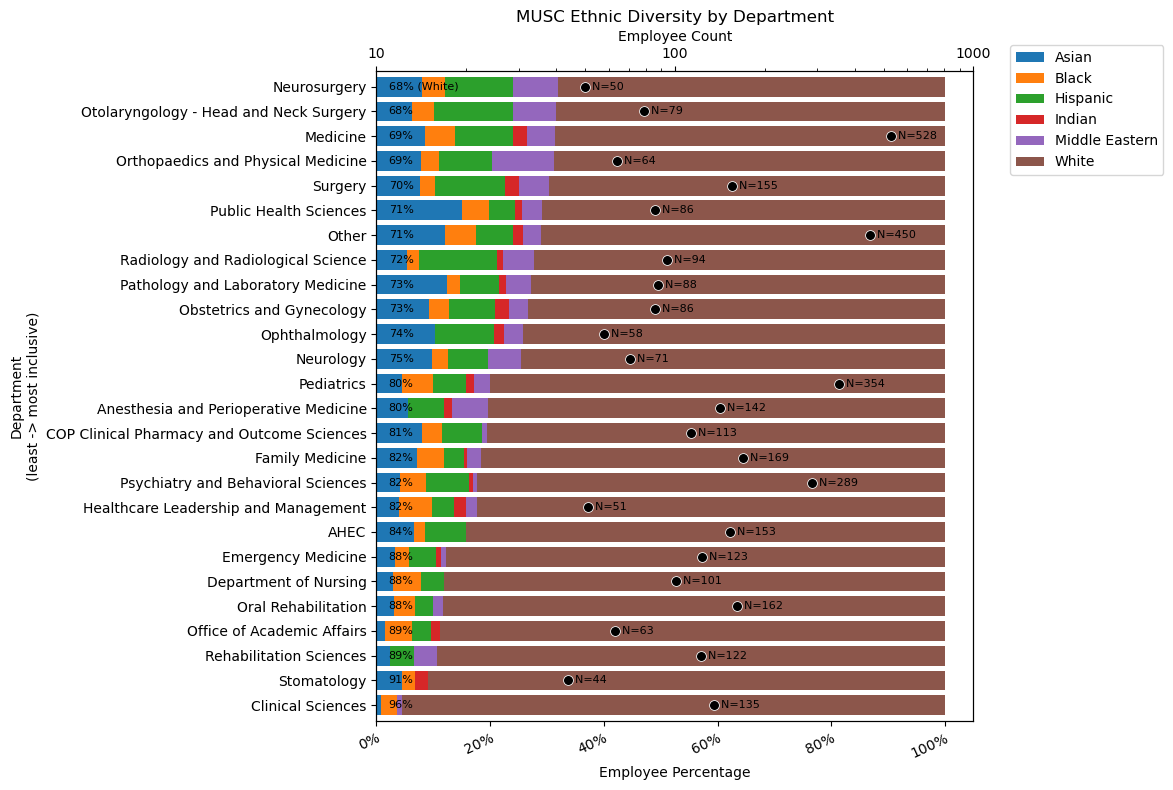

In [8]:

def visualize():
    df = get_clean_data()

    top_departments = df['department'].value_counts().head(25).index
    df['department'] = df['department'].apply(lambda x: x if x in top_departments else 'Other')

    
    grouped = df.groupby(['department', 'ethnicity']).size().unstack().fillna(0)
    grouped_fraction = grouped.div(grouped.sum(axis=1), axis=0)
    grouped_sorted = grouped_fraction.sort_values(by='White', ascending=True)
    grouped_count_sorted = grouped.sum(axis=1).loc[grouped_sorted.index]

    fig, ax1 = plt.subplots(figsize=(12, 8))

    grouped_sorted.plot(kind='barh', stacked=True, ax=ax1, width=.8)
    ax1.set_xlabel('Employee Percentage')
    ax1.set_ylabel('Department\n(least -> most inclusive)')
    ax1.xaxis.set_major_formatter(PercentFormatter(1))

    ax2 = ax1.twiny()
    sns.scatterplot(y=grouped_sorted.index, x=grouped_count_sorted.values, ax=ax2, color='k', marker='o', s=50)
    ax2.set_xlabel('Employee Count')
    ax2.set_xscale('log')
    ax2.set_xticks([10, 100, 1000])
    ax2.get_xaxis().set_major_formatter(ScalarFormatter())

    for i, count in enumerate(grouped_count_sorted.values):
        pct = grouped_sorted['White'].values[i]
        ax2.text(11, i, f"{pct:.0%}" if i > 0 else f"{pct:.0%} (White)", ha='left', va='center', fontsize=8)
        ax2.text(count, i, f"  N={count:.0f}", ha='left', va='center', fontsize=8)
    
    ax1.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
    ax1.set_title('MUSC Ethnic Diversity by Department')
    plt.setp(ax1.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

visualize()

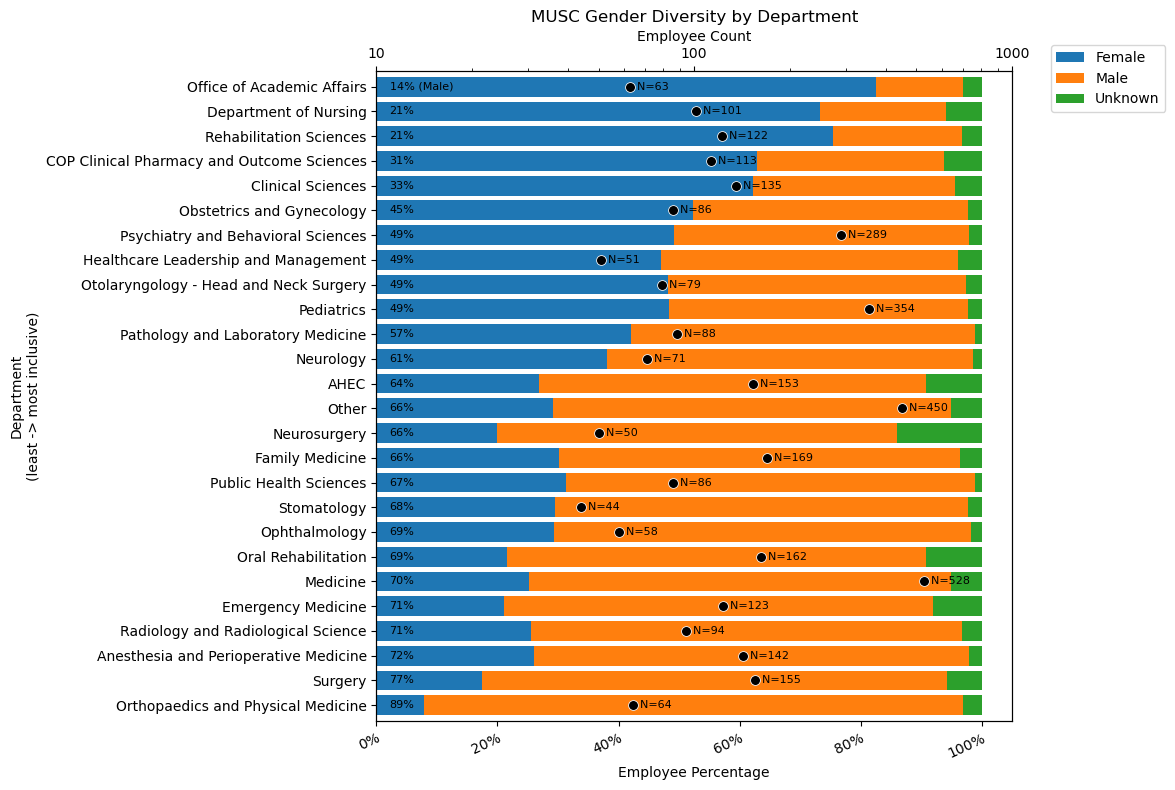

In [9]:
def visualize():
    df = get_clean_data()

    top_departments = df['department'].value_counts().head(25).index
    df['department'] = df['department'].apply(lambda x: x if x in top_departments else 'Other')

    
    grouped = df.groupby(['department', 'gender']).size().unstack().fillna(0)
    grouped_fraction = grouped.div(grouped.sum(axis=1), axis=0)
    grouped_sorted = grouped_fraction.sort_values(by='Male', ascending=True)
    grouped_count_sorted = grouped.sum(axis=1).loc[grouped_sorted.index]

    fig, ax1 = plt.subplots(figsize=(12, 8))

    grouped_sorted.plot(kind='barh', stacked=True, ax=ax1, width=.8)
    ax1.set_xlabel('Employee Percentage')
    ax1.set_ylabel('Department\n(least -> most inclusive)')
    ax1.xaxis.set_major_formatter(PercentFormatter(1))

    ax2 = ax1.twiny()
    sns.scatterplot(y=grouped_sorted.index, x=grouped_count_sorted.values, ax=ax2, color='k', marker='o', s=50)
    ax2.set_xlabel('Employee Count')
    ax2.set_xscale('log')
    ax2.set_xticks([10, 100, 1000])
    ax2.get_xaxis().set_major_formatter(ScalarFormatter())

    for i, count in enumerate(grouped_count_sorted.values):
        pct = grouped_sorted['Male'].values[i]
        ax2.text(11, i, f"{pct:.0%}" if i > 0 else f"{pct:.0%} (Male)", ha='left', va='center', fontsize=8)
        ax2.text(count, i, f"  N={count:.0f}", ha='left', va='center', fontsize=8)
    
    ax1.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
    ax1.set_title('MUSC Gender Diversity by Department')
    plt.setp(ax1.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

visualize()